### I hope that this notebook is helpful to enjoy the competition.

## Model
- for training:  
backbone(CLIP) + Dropout + Dense(units=256) + Arcface + Softmax (classes=17691)
- for inference:  
backbone(CLIP) + Dropout + Dense(units=256) + AdaptiveAveragePooling(n=64)

Note:  
[Discussion](https://www.kaggle.com/competitions/google-universal-image-embedding/discussion/337384#1908364)  
The CLIP in TensorFlow cannot work well on kaggle TPU notebook.  
If you train it with TPU, I recommend to implement on google colab.

## Dataset for training:  
- [imagenet1k](https://www.kaggle.com/datasets/motono0223/guie-imagenet1k-mini1-tfrecords-label-0-999)  
  This dataset was created from imagenet(1k) dataset.  
  To reduce the dataset size, this dataset has only 50 images per class.  

- [products10k](https://www.kaggle.com/datasets/motono0223/guie-products10k-tfrecords-label-1000-10690)  
  This dataset was created from [the product10k dataset](https://products-10k.github.io/).   
  To reduce the dataset size, this dataset has only 50 images per class.  

- [google landmark recognition 2021(Competition dataset)](https://www.kaggle.com/datasets/motono0223/guie-glr2021mini-tfrecords-label-10691-17690)  
  This dataset was created from [the competition dataset](https://www.kaggle.com/competitions/landmark-recognition-2021/data).  
  To reduce the dataset size, this dataset uses the top 7k class images with a large number of images (50 images per class).  


# Possible ideas
- add rotation of images to the model
- use not top 50 classes, but a random range of classes
- check to see that we use all of training data as a final round of training
- nice to have: remove magic numbers from training

# Libraries

In [1]:
import os
def is_colab_env():
    is_colab = False
    for k in os.environ.keys():
        if "COLAB" in k:
            is_colab = True
            break
    return is_colab

# if google colab, install transformers and tensorflow_addons
# (Note: please use google colab(TPU) when model is trained. 
#  On the kaggle TPU env, the module transformers.TFCLIPVisionModel couldn't be installed.)
if is_colab_env():
    # if it is a colab env, install these libs
    !pip install transformers
    !pip install tensorflow_addons

In [4]:
from transformers import CLIPProcessor, TFCLIPVisionModel, CLIPFeatureExtractor

import re
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import gc
import requests
from mpl_toolkits import axes_grid1

# Device

In [5]:
import tensorflow as tf
try:
    # dectect and init TPU - turn on by accelerator switch
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    
except ValueError: # if no TPU
    tpu = None

# use TPU if availabple
if tpu:
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu) # distribute training among different tpu
else:
    print("using GPU/CPU ", tf.config.list_physical_devices(device_type=None))
    # list the available devices
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

using GPU/CPU  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
REPLICAS:  1


## Clip
- train on image, text pairs
- zero-shot learning: do well tasks not trained on
- bc of this, it can predict classes not seen before
- use image embedding: map image to a location in a x-dim vector
- has image and text encoding
- images be close to the text after encoding both
- use cosine similarity
- want cosine similarity to be low between things not similar
- take long time to train (why preload weights in class)

In [7]:
# If GPU instance, it makes mixed precision enable.
if strategy.num_replicas_in_sync == 1:

    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    # use both the 16-bit and 32-bit float vlaues
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)

2022-10-03 03:25:16.695972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
# a class to hold configuration of training
# holds the CLIP model, preloaded weights, randomization seed, number classes, LR, epochs, Batch size
class config:
    VERSION = 3
    SUBV = "Clip_ViT_Train" # sub version

    SEED = 42 # the randomization seed

    # pretrained model
    RESUME = True
    RESUME_EPOCH = 0
    RESUME_WEIGHT = "../input/guei-v6-clip-vit-large-arcface-train-projection/clip-vit-large-patch14_224pix-emb256_arcface_entire.h5"

    # backbone model
    # feature extracting network
    model_type = "clip-vit-large-patch14"
    EFF_SIZE = 0
    EFF2_TYPE = ""
    IMAGE_SIZE = 224

    # projection layer
    N_CLASSES = 17691 # the number of classifications for the classes
    EMB_DIM = 256  # = 64 x N
    
    # training
    TRAIN = False
    BATCH_SIZE = 150 * strategy.num_replicas_in_sync
    EPOCHS = 150
    LR = 0.001
    save_dir = "./"

    DEBUG = True
    

# Function to seed everything (set randomness)
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# Determine the full model name
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_SIZE}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF2_TYPE}'
elif "swin" in config.model_type:
    MODEL_NAME = config.model_type
elif "conv" in config.model_type:
    MODEL_NAME = config.model_type
else:
    MODEL_NAME = config.model_type
config.MODEL_NAME = MODEL_NAME

print(MODEL_NAME)

# TFRecords
- way to store data
- stored sequentially - faster read tiems when compared to numpy array
-

In [ ]:
if is_colab_env(): # for google colab env.
    # load in the data sets: products10k glr2021mini imagenet1k
    kaggle_backet_dict = {
        "guie-imagenet1k-mini1-tfrecords-label-0-999" : "gs://kds-33230144c2940b6311609dcfaaa9841a44508cd149b0616d5e5fb5c2",
        "guie-products10k-tfrecords-label-1000-10690" : "gs://kds-2ae72f61d1fe606ae8aa6af28c61cd39530fefb9797fd88946ac6037",
        "guie-glr2021mini-tfrecords-label-10691-17690" : "gs://kds-f25e426fa1a600c0fb6cdbfddbb34802a11bed80cf42a4c18baa2fb9",
    }
else: # for kaggle notebook
    from kaggle_datasets import KaggleDatasets

In [ ]:
def get_num_of_image(file):
    return int(file.split("/")[-1].split(".")[0].split("-")[-1])

train_set_len = sum( [ get_num_of_image(file) for file in train_set_path ] )
valid_set_len = sum( [ get_num_of_image(file) for file in valid_set_path ] )

train_set_len, valid_set_len

In [ ]:
train_shard_suffix = '*-train-*.tfrec'

ROOT_DIRS  = [
    "guie-glr2021mini-tfrecords-label-10691-17690",
    "guie-imagenet1k-mini1-tfrecords-label-0-999",
    "guie-products10k-tfrecords-label-1000-10690",
]

train_set_path = []
valid_set_path = []
for ROOT_DIR in ROOT_DIRS: # for each dataset
    if is_colab_env():
        GCS_DS_PATH = kaggle_backet_dict[ ROOT_DIR ]
    else:
        GCS_DS_PATH = KaggleDatasets().get_gcs_path( ROOT_DIR )

    print( f"\"{ROOT_DIR}\" : \"{GCS_DS_PATH}\"," )
    files = sorted(tf.io.gfile.glob(GCS_DS_PATH + f'/{train_shard_suffix}'))
    # split data
    # TODO: try tinkering with percent data used in val and train, potentially setting all data to the
    train_set_path += random.sample(files, int( len(files) * 0.9 ) ) # add on 90% to training data
    valid_set_path += [ file for file in files  if not file in train_set_path ] # add on remaining to training data
    print(ROOT_DIR, ", number of tfrecords = ", len(files))

# sort the data
train_set_path = sorted( train_set_path )
valid_set_path = sorted( valid_set_path )

print("# of tfrecords for training   : ", len(train_set_path))
print("# of tfrecords for validation : ", len(valid_set_path))

# not running full: use less data.
if config.DEBUG:
    # TODO: move 4 to a variable in the config class
    train_set_path = random.sample( train_set_path, 4)
    print("debug: reduce training data. num=", len(train_set_path))

    valid_set_path = train_set_path #valid_set_path[:1]
    print("debug: reduce validation data. num=", len(valid_set_path))

# Dataset pipeline
- converts the raw examples (i/o pair) to an image and its label

In [ ]:
def deserialization_fn(serialized_example):
    # examples stored in TFrecords, pass 1 exmaple to process it
    parsed_example = tf.io.parse_single_example( # example contains a image class, and a label for that image
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, size=(config.IMAGE_SIZE, config.IMAGE_SIZE)) # TODO: try changing the image size
    label = tf.cast(parsed_example['image/class/label'], tf.int64)
    image = tf.cast(image, tf.float32) / 255.0 # resize to 0-1
    return image, label # return the processed data

In [ ]:
class Augmentation:
    MIN_ROT=-45
    MAX_ROT=45
    ROTATE=True
    HUE=0.1
    MIN_SAT=0.7
    MAX_SAT=1.3
    MIN_CONT=0.80
    MAX_CONT=1.20
    BRIGHT=0.10
    FLIP_LR=True
    FLIP_UD=True
    
    

In [ ]:
# arcFace: model takes 2 face images as input and outputs the distance between them
def arcface_format(image, label_group):
    return {'inp1': image, 'inp2': label_group}, label_group
# convert image to 0-255 pixel size
def rescale_image(image, label_group):
    image = tf.cast(image, tf.float32) * 255.0
    return image, label_group

def data_augment(image, label_group):
    # TODO: try shifting the image around and see what you get
    if Augmentation.FLIP_UD:
        image = tf.image.stateless_random_flip_up_down(image)
    #image = tf.image.random_flip_up_down(image)
    if Augmentation.FLIP_LR:
        image = tf.image.stateless_random_flip_left_right(image)

    if Augmentation.ROTATE:
        degrees = tf.random.stateless_uniform(minval=Augmentation.MIN_ROT, maxval=Augmentation.MAX_ROT)
        degrees = degrees*0.017453292519943295
        image = tfa.image.rotate(image, degrees)
    image = tf.image.stateless_random_hue(image, Augmentation.HUE)
    image = tf.image.stateless_random_saturation(image, Augmentation.MIN_SAT, Augmentation.MAX_SAT)
    image = tf.image.stateless_random_contrast(image, Augmentation.MIN_CONT, Augmentation.MAX_CONT)
    image = tf.image.stateless_random_brightness(image, Augmentation.BRIGHT)

    
    
    return image, label_group

# Dataset to obtain backbone's inference
def get_backbone_inference_dataset(tfrecord_paths, cache=False, repeat=False, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_paths) # represents lasrge dataset, all of the training data
    data_len = sum( [ get_num_of_image(file) for file in tfrecord_paths ] )
    dataset = dataset.shuffle( data_len//10 ) if shuffle else dataset # shouffle data after each epoch training
    dataset = dataset.flat_map(tf.data.TFRecordDataset) # combines different TFRecords for a dataset, have large list of data
    #dataset.map: apply the deserialization_fn to each dataset
    dataset = dataset.map(deserialization_fn, num_parallel_calls=AUTO) # image[0-1], label[0-999]

    if augment:
        # apply augment func to each element
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)  # (image, label_group) --> (image, label_group)
    # apply rescale func to each eelement (convert back to 0-255 rgb)
    # working with 0-255 as prior to this, flattened to 0-1
    dataset = dataset.map(rescale_image, num_parallel_calls = AUTO)  # image[0-1], label[0-n_classes] --> image[0-255], label[0-n_classes]
    # convert to arcface format (distance between 2 images)
    dataset = dataset.map(arcface_format, num_parallel_calls=AUTO)   # (image, label_group) --> ({"inp1":image, "inp2":label_group}, label_group )
    if repeat:
        dataset = dataset.repeat()
    # init the dataset, spliting the examples into batches
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [17]:
# arcFace: model takes 2 face images as input and outputs the distance between them
def arcface_format(image, label_group):
    return {'inp1': image, 'inp2': label_group}, label_group
# convert image to 0-255 pixel size
def rescale_image(image, label_group):
    image = tf.cast(image, tf.float32) * 255.0
    return image, label_group
def augment_image(image, seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    image = tf.image.stateless_random_brightness(image, max_delta=0.3, seed=new_seed)
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = tf.image.stateless_random_flip_left_right(image, seed=new_seed)
    image = tf.image.stateless_random_flip_up_down(image, seed=new_seed)
    return image, label, seed
# Data augmentation function
def data_augment(image, label_group):
    # TODO: try shifting the image around and see what you get
    
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.stateless_random_flip_left_right(image)
    image = tf.image.stateless_random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)

    
    
    return image, label_group

# Dataset to obtain backbone's inference
def get_backbone_inference_dataset(tfrecord_paths, cache=False, repeat=False, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_paths) # represents lasrge dataset, all of the training data
    data_len = sum( [ get_num_of_image(file) for file in tfrecord_paths ] )
    dataset = dataset.shuffle( data_len//10 ) if shuffle else dataset # shouffle data after each epoch training
    dataset = dataset.flat_map(tf.data.TFRecordDataset) # combines different TFRecords for a dataset, have large list of data
    #dataset.map: apply the deserialization_fn to each dataset
    dataset = dataset.map(deserialization_fn, num_parallel_calls=AUTO) # image[0-1], label[0-999]

    if augment:
        # apply augment func to each element
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)  # (image, label_group) --> (image, label_group)
    # apply rescale func to each eelement (convert back to 0-255 rgb)
    # working with 0-255 as prior to this, flattened to 0-1
    dataset = dataset.map(rescale_image, num_parallel_calls = AUTO)  # image[0-1], label[0-n_classes] --> image[0-255], label[0-n_classes]
    # convert to arcface format (distance between 2 images)
    dataset = dataset.map(arcface_format, num_parallel_calls=AUTO)   # (image, label_group) --> ({"inp1":image, "inp2":label_group}, label_group )
    if repeat:
        dataset = dataset.repeat()
    # init the dataset, spliting the examples into batches
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Viz tfrecord images

2022-10-03 03:30:24.243336: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(15, 224, 224, 3)


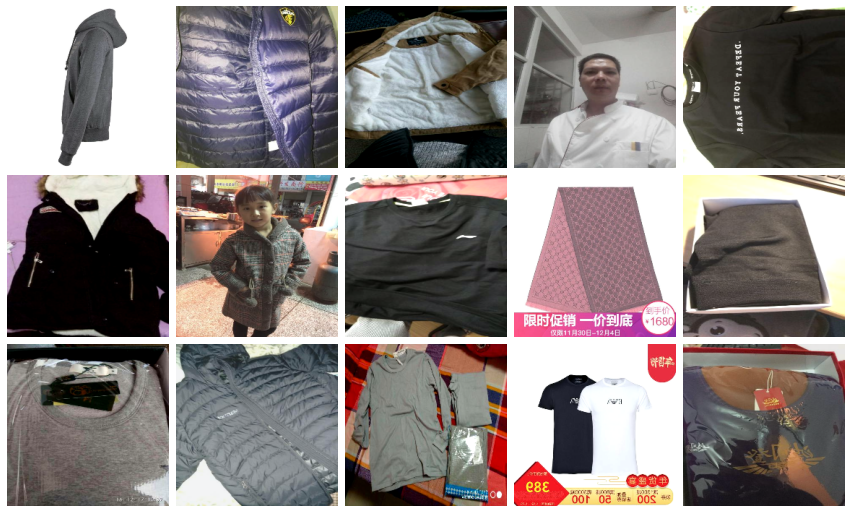

In [18]:
backbone_infer_dataset_encode = get_backbone_inference_dataset(train_set_path, shuffle=True, augment=True)
# display some images in 15x15 pixel size to see the data being used with the labels
num_cols = 3
num_rows = 5
backbone_infer_dataset_encode = backbone_infer_dataset_encode.unbatch().batch(num_cols * num_rows)
x, y = next(iter(backbone_infer_dataset_encode))
print(x["inp1"].shape)

fig = plt.figure(figsize=(15, 15))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.1)

for i, ax in enumerate(grid):
    ax.imshow(x["inp1"][i]/255)
    ax.axis("off")

del backbone_infer_dataset_encode

# Model

In [20]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.
    - a loss func used in face recognition
    - uses cosine similarity
    -

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):
        # return configuration of model
        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        # use existing class and pass in the input shape
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)
    # only accepts tensors as input (i/o pair)
    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32) # the output class
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2)) # trig identify
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output # return the predicted output in embedded space

In [21]:
def get_scale_layer(rescale_mode = "tf"):
    # For keras_cv_attention_models module:
    # ref: https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/imagenet/data.py
    # ref function : init_mean_std_by_rescale_mode()

    # For effV2 (21k classes) : https://github.com/leondgarse/keras_efficientnet_v2

    if isinstance(rescale_mode, (list, tuple)):  # Specific mean and std
        mean, std = rescale_mode
    elif rescale_mode == "torch":
        mean = np.array([0.485, 0.456, 0.406]) * 255.0
        std = np.array([0.229, 0.224, 0.225]) * 255.0
    elif rescale_mode == "tf":  # [0, 255] -> [-1, 1]
        mean, std = 127.5, 127.5
    elif rescale_mode == "tf128":  # [0, 255] -> [-1, 1]
        mean, std = 128.0, 128.0
    elif rescale_mode == "raw01":
        mean, std = 0, 255.0  # [0, 255] -> [0, 1]
    else:
        mean, std = 0, 1  # raw inputs [0, 255]        
    scaling_layer = keras.layers.Lambda(lambda x: ( tf.cast(x, tf.float32) - mean) / std )
    # arbitrary expressions: lamda:
    # help whe nbuilding sequental and functional API midels
    # have the function, and here we nromalize the input vector according to the mean and std of model
    
    return scaling_layer


def get_clip_model():
    # define the input shape to be 3 channels each 224 by 224 pixels
    inp = tf.keras.layers.Input(shape = [3, 224, 224]) # [B, C, H, W]
    backbone = TFCLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")
    # the output is the vectorized image
    output = backbone({'pixel_values':inp}).pooler_output
    return tf.keras.Model(inputs=[inp], outputs=[output])

def get_embedding_model():
    #------------------
    # Definition of placeholders
    inp = tf.keras.layers.Input(shape = [None, None, 3], name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')

    # Definition of layers
    layer_resize = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [config.IMAGE_SIZE, config.IMAGE_SIZE]), name='resize')
    layer_scaling = get_scale_layer(rescale_mode = "torch") # first scale the layers of the image, have different rescale inputs
    layer_permute = tf.keras.layers.Permute((3,1,2)) # change the fields form R,G,B to B,R,G
    layer_backbone = get_clip_model() # load the CLIp model
    layer_dropout = tf.keras.layers.Dropout(0.2) # have dropout (randomly set input nodes to 0 to prevent overfitting
    layer_dense_before_arcface = tf.keras.layers.Dense(config.EMB_DIM) # the input length ie N*256 - the dimensions ie 2*256
    layer_margin = ArcMarginProduct(
        n_classes = config.N_CLASSES, 
        s = 30, 
        m = 0.3, 
        name=f'head/arcface', 
        dtype='float32'
        )
    # activation function
    layer_softmax = tf.keras.layers.Softmax(dtype='float32')
    layer_l2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name='embedding_norm')
    
    if config.EMB_DIM != 64:
        layer_adaptive_pooling = tfa.layers.AdaptiveAveragePooling1D(64)
    else:
        layer_adaptive_pooling = tf.keras.layers.Lambda(lambda x: x )  # layer with no operation

    #------------------
    # Definition of entire model
    image = layer_scaling(inp) # scaling: normalize image according to a mean and standard deviation
    image = layer_resize(image) # resize the image to have it be in desired image size 256x256
    image = layer_permute(image) # change the channel layout bc BGR training is better than RGB
    backbone_output = layer_backbone(image) # the encoded clip model for producing vectorized input and output pairs
    embed = layer_dropout(backbone_output) # dropout: randomly deactivate nuerons to prevent overfitting
    embed = layer_dense_before_arcface(embed) # the output of the encoding of the vectors
    x = layer_margin([embed, label]) # the actual conversion from one to the other via cosine similarity
    output = layer_softmax(x) # activation function of the layer_margin
    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output]) # whole architecture

    model.layers[-6].trainable = False
    opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
    model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
        )

    #------------------
    # Definition of embedding model (for submission)
    embed_model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(None, None, 3), dtype='uint8'),
        layer_scaling,
        layer_resize,
        layer_permute,
        layer_backbone,
        layer_dropout,
        layer_dense_before_arcface,
        layer_adaptive_pooling,    # shape:[None, config.EMB_DIM] --> [None, 64]
        layer_l2,
    ])


    return model, embed_model

In [22]:
with strategy.scope():
    model, emb_model = get_embedding_model()

if config.RESUME:
    print(f"load {config.RESUME_WEIGHT}")
    model.load_weights( config.RESUME_WEIGHT )
    #emb_model.load_weights( config.RESUME_WEIGHT )

Downloading:   0%|          | 0.00/4.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

2022-10-03 03:32:35.615232: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
Some layers from the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing TFCLIPVisionModel: ['clip/text_model/encoder/layers_._8/mlp/fc2/kernel:0', 'clip/text_model/encoder/layers_._10/self_attn/v_proj/bias:0', 'clip/text_model/encoder/layers_._2/self_attn/k_proj/kernel:0', 'clip/text_model/encoder/layers_._1/layer_norm2/beta:0', 'clip/text_model/encoder/layers_._2/layer_norm2/beta:0', 'clip/text_model/encoder/layers_._8/layer_norm1/beta:0', 'clip/text_model/encoder/layers_._8/self_attn/v_proj/bias:0', 'clip/text_model/encoder/layers_._3/layer_norm2/beta:0', 'clip/text_model/encoder/layers_._10/layer_norm2/beta:0', 'clip/text_model/encoder/layers_._6/layer_norm2/gamma:0', 'clip/text_model/encoder/layers_._2/self_attn/q_proj/bias:0', 'clip/text_model/encoder/layers_._6/layer_norm1/gamma:0', 'clip/text_model/encoder/layers_._10/self_attn/k_proj/bias:0', '

load ../input/guei-v6-clip-vit-large-arcface-train-projection/clip-vit-large-patch14_224pix-emb256_arcface_entire.h5


In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           inp1[0][0]                       
__________________________________________________________________________________________________
resize (Lambda)                 (None, 224, 224, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
permute (Permute)               (None, 3, 224, 224)  0           resize[0][0]                     
____________________________________________________________________________________________

In [24]:
emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, None, 3)     0         
_________________________________________________________________
resize (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
permute (Permute)            (None, 3, 224, 224)       0         
_________________________________________________________________
model (Functional)           (None, 1024)              303179776 
_________________________________________________________________
dropout_24 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
adaptive_average_pooling1d ( (None, 64)                0

# Scheduler

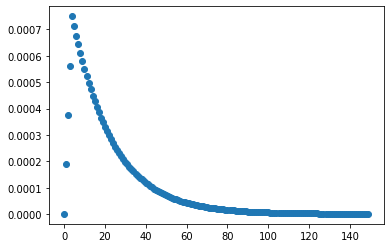

In [25]:
# a way to decrease learning rate over time. As epoch increase, decrease the learning rate
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.95
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

# Train entire model 

In [27]:
if config.TRAIN:
    sv_loss = tf.keras.callbacks.ModelCheckpoint(
        config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_loss.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')

    steps_per_epoch = train_set_len // config.BATCH_SIZE  // 10     # "//10" means that the lr is update every 0.1 epoch.
    validation_steps = valid_set_len // config.BATCH_SIZE
    if valid_set_len % config.BATCH_SIZE != 0:
        validation_steps += 1
    print(steps_per_epoch, validation_steps)
    # get the train and validation datasets
    ds_train = get_backbone_inference_dataset(train_set_path, shuffle=True, augment=True, repeat=True)
    ds_valid = get_backbone_inference_dataset(valid_set_path, shuffle=False, augment=False, repeat=False)
    # fit the model using the overidden fucntion and the config paramters
    history = model.fit(
        ds_train,
        epochs=config.EPOCHS,
        callbacks=[get_lr_callback(), sv_loss], # the adjustment for the LR over time
        steps_per_epoch=steps_per_epoch, # number of adjustments per epoch
        validation_data = ds_valid, # validation data
        validation_steps = validation_steps, # number of steps for the validation
        verbose=1 # engage debugging
    )

    # load best weight 
    model.load_weights( config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_entire.h5" )

In [ ]:
# save for debug
emb_model.save_weights( config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_emb_model.h5" )

# Create submission.zip

In [ ]:
save_locally = tf.saved_model.SaveOptions(
    experimental_io_device='/job:localhost'
)
emb_model.save('./embedding_norm_model', options=save_locally)

from zipfile import ZipFile

with ZipFile('submission.zip','w') as zip:           
    zip.write(
        './embedding_norm_model/saved_model.pb', 
        arcname='saved_model.pb'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.data-00000-of-00001', 
        arcname='variables/variables.data-00000-of-00001'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.index', 
        arcname='variables/variables.index'
    )